# Import modules

In [34]:
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict
import re
import itertools

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model, Sequence
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [3]:
BASE_DIR = '/kaggle/input/flickr-image-dataset/flickr30k_images'
WORKING_DIR = '/kaggle/working'

# Extract image features

In [4]:
# load VGG16 model
model = VGG16()

# restructure the model
# just only need the previous layers in order to extract the feature results
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

I0000 00:00:1746015138.712812     281 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746015138.713549     281 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# extract features from image
features = {}

# Define valid image extensions
valid_extensions = {'.jpg', '.jpeg', '.png'}

directory = os.path.join(BASE_DIR, 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory, img_name)

    if not os.path.isfile(img_path) or not any(img_name.lower().endswith(ext) for ext in valid_extensions):
        print(f"Skipping directory or non-file: {img_path}")
        continue
        
    image = load_img(img_path, target_size=(224, 224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for VGG16
    image = preprocess_input(image)

    # extract features
    feature = model.predict(image, verbose=0)

    # get image ID
    image_id = img_name.split('.')[0]

    # store feature
    features[image_id] = feature

In [ ]:
# extracted the features -> do not want to lose the features agains or else have to re-extract it -> it takes a long time

# store features in pickle

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with(open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb')) as f:
    features = pickle.load(f)

# Load the captions data

In [7]:
captions = pd.read_csv(os.path.join(BASE_DIR, 'results.csv'), sep='|')
captions.columns = [col.strip() for col in captions.columns]

In [8]:
# create mappings of image_id to list of captions
# `defaultdict(list)` automatically creates a list if img_id is not yet in mappings
mappings = defaultdict(list)

for _, row in tqdm(captions.iterrows()):
    mappings[row['image_name'].split('.')[0]].append(row['comment'])

0it [00:00, ?it/s]

In [9]:
len(mappings)

31783

# Preprocessing the captions data

In [10]:
def clean(mappings):
    for _ , captions in tqdm(mappings.items()):
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]

            # skip if caption is NaN or not a string
            if not isinstance(caption, str):
                continue

            # preprocessing steps
            caption = re.sub('[^A-Za-z\s]', '', caption) # replace/remove if not the characters (digits, special chars,...)
            caption = caption.lower() # lower the characters
            # \s: This is a character class that matches any whitespace character. This includes spaces, tabs (\t), newlines (\n), and carriage returns (\r). 
            caption = re.sub(r'\s+', ' ', caption).strip() # remove additional whitespace to single whitespace

            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'

            captions[i] = caption

clean(mappings)

  0%|          | 0/31783 [00:00<?, ?it/s]

In [11]:
all_captions = list(itertools.chain(*mappings.values()))
all_captions = [caption for caption in all_captions if isinstance(caption, str)]

In [12]:
# Tokenize the valid captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 19750


In [13]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(f"The longest sequence's length: {max_length}")

The longest sequence's length: 74


# Train-Test split

In [14]:
train, test = train_test_split(list(mappings.keys()), train_size=0.9, test_size=0.1, random_state=42, shuffle=True)

In [19]:
class DataGenerator(Sequence):
    def __init__(self, data_keys, mappings, features, tokenizer, max_length, vocab_size, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.data_keys = data_keys
        self.mappings = mappings
        self.features = features
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.data_keys) // (self.batch_size * 2) # for faster

    def on_epoch_end(self):
        np.random.shuffle(self.data_keys)

    def __getitem__(self, idx):
        X1, X2, y = list(), list(), list()
        keys = self.data_keys[idx * self.batch_size:(idx + 1) * self.batch_size]

        for key in keys:
            captions = self.mappings[key]
            for caption in captions:
                if not isinstance(caption, str):
                    caption = str(caption) if caption is not None else ""

                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                    X1.append(self.features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

        return (np.array(X1), np.array(X2)), np.array(y)

# Model creation

<div align='center'>

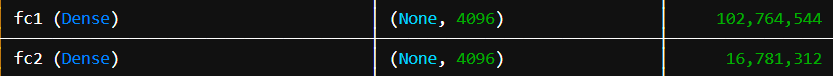
    
</div>

In [20]:
# encoder model 

# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model 
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam')

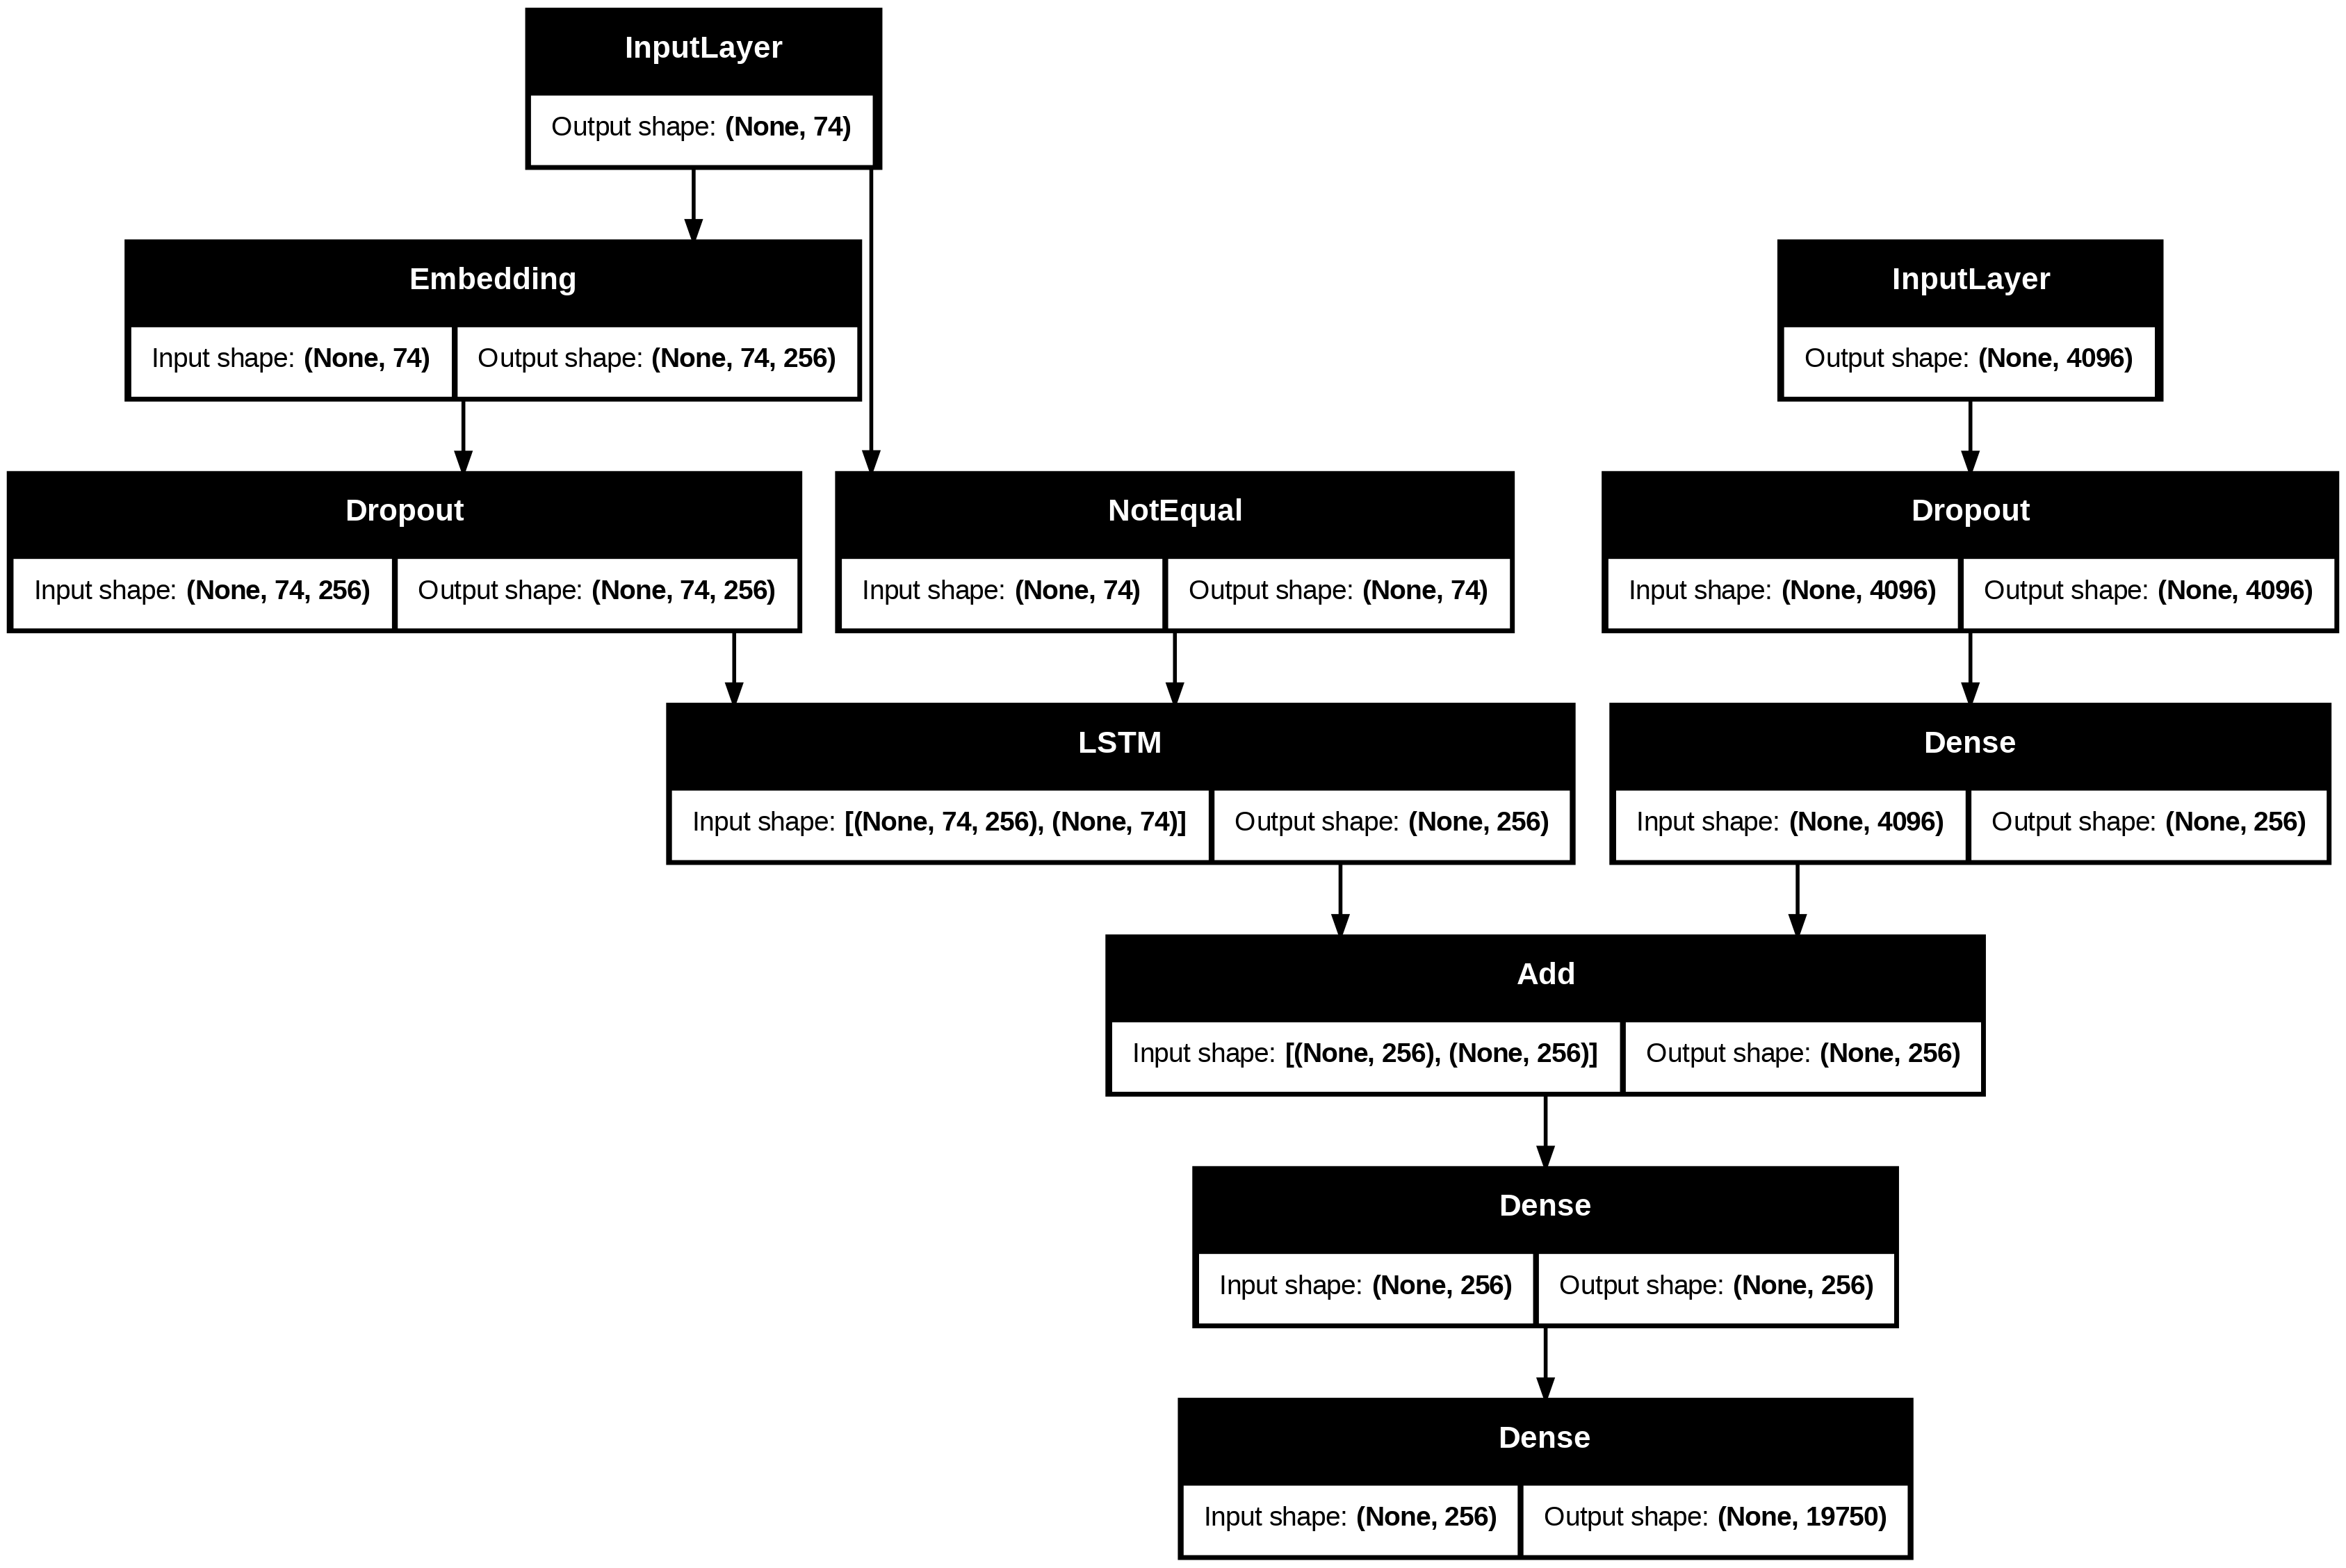

In [21]:
# Plot the model
plot_model(model, show_shapes=True)

In [22]:
batch_size = 32

generator = DataGenerator(train, mappings, features, tokenizer, max_length, vocab_size, batch_size)
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 212s 461ms/step - loss: 5.7923
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 210s 462ms/step - loss: 4.2141
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 210s 463ms/step - loss: 3.8967
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 210s 462ms/step - loss: 3.7063
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 210s 461ms/step - loss: 3.5532
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 208s 459ms/step - loss: 3.4543
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 208s 458ms/step - loss: 3.3734
Epoch 8/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 210s 462ms/step - loss: 3.2979
Epoch 9/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 209s 459ms/step - loss: 3.2348
Epoch 10/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 209s 460ms/step - loss: 3.1870


In [23]:
model.save(WORKING_DIR + '/best_model.h5')

# Generate captions for the image

In [41]:
index_word = {index: word for word, index in tokenizer.word_index.items()}
def idx_to_word(integer, tokenizer):
    return index_word.get(integer)

In [44]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = idx_to_word(yhat, tokenizer)
        
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [45]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mappings[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()

    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

smoothing = SmoothingFunction().method4

# calculate BLEU score
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothing):.4f}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing):.4f}')
print(f'BLEU-3: {corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing):.4f}')
print(f'BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing):.4f}')

  0%|          | 0/3179 [00:00<?, ?it/s]

BLEU-1: 0.5763
BLEU-2: 0.3356
BLEU-3: 0.2107
BLEU-4: 0.1235


# Visualize the results

In [46]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    
    img_path = os.path.join(BASE_DIR, "flickr30k_images", image_name)
    image = Image.open(img_path)
    
    captions = mappings[image_id]
    
    print('---------------Actual---------------')
    for caption in captions:
        print(caption)
    
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('---------------Predicted---------------')
    print(y_pred)
    
    plt.imshow(image)

---------------Actual---------------
startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq
startseq two young white males are outside near many bushes endseq
startseq two men in green shirts are standing in yard endseq
startseq man in blue shirt standing in garden endseq
startseq two friends enjoy time spent together endseq
---------------Predicted---------------
startseq two children are playing in park endseq


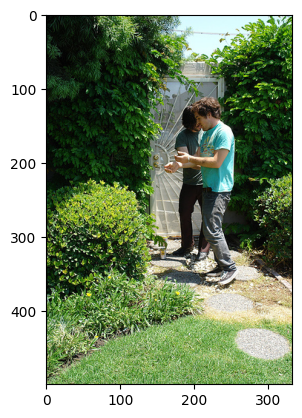

In [47]:
generate_caption(image_name='1000092795.jpg')